# SN Ia validation plots

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from astropy import table
import seaborn as sns

In [2]:
dc2full = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2full_pzRedshifts_31Healpix_sdss_updMag_Rkpc_Final.tar.gz")

In [3]:
# Import GHOST data
file = '../../data_files/GHOST_restFrame_condenseLabels_0323.csv'
ghost = pd.read_csv(file)
print(ghost.columns)
print(len(ghost))
print(np.unique(ghost['TransientClass']))
ghost = ghost[ghost['TransientClass'] == 'SN Ia']
ghost.reset_index(inplace=True)
print("Number of {:s}: {:d}".format('SN Ia',len(ghost)))
transient_class = ghost['TransientClass']
gG = ghost['gKronMag_SDSS_abs']
gR = ghost['rKronMag_SDSS_abs']
gI = ghost['iKronMag_SDSS_abs']
gZ = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']

og_ghost_idx = np.arange(len(ghost))
# first remove all -999s:
keydata = np.vstack((gG, gR, gI, gZ, g_gr, g_ri, g_iz, g_ellip, g_rshift, g_rshift2)).T

keydata[np.logical_or(keydata<-50,keydata>100)] = np.nan

print("original length: ", len(keydata))

# get rid of redshifts with nan
delete_znans = []
z_nans = 0
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        z_nans += 1
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        # if transient redshift is not nan, replace with transient redshift
        if not np.isnan(keydata[i,9]):
            keydata[i,8] = keydata[i,9]
        else:
            delete_znans.append(i)
    if keydata[i,8] <= 0:
        delete_znans.append(i)

keydata = np.delete(keydata, delete_znans, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_znans)

print("Redshift = nan cut, cut to: ", len(keydata))

delete_rows = []
# delete rows with more than one nan
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        nan_counter = 0
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                nan_counter+=1
        if nan_counter > 1:
            delete_rows.append(i)
#     for j in range(2,6): # the magnitudes
#         if keydata[i,j]<0 or keydata[i,j]>25.:
#             delete_rows.append(i)

keydata = np.delete(keydata, delete_rows, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_rows)
print("Multiple nans cut, cut to ", len(keydata))

# finally for rows with just one nan, replace with the average value
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                keydata[i,j] = np.nanmean(keydata[:,j])
gG = keydata[:,0]
gR = keydata[:,1]
gI = keydata[:,2]
gZ = keydata[:,3]
g_gr = keydata[:,4]
g_ri   = keydata[:,5]
g_iz   = keydata[:,6]
g_ellip = keydata[:,7]
g_rshift = keydata[:,8]


Index(['TransientClass', 'objID', 'raMean', 'decMean', 'NED_redshift',
       'TransientRedshift', 'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag',
       'rApMag', 'rPSFMag', 'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag',
       'zApMag', 'zPSFMag', 'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr',
       'gApMagErr', 'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr',
       'iKronMagErr', 'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr',
       'zPSFMagErr', 'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i',
       'i-z', 'z-y', 'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip',
       'r_ellip', 'i_ellip', 'z_ellip', 'g-r_SDSS_rest', 'r-i_SDSS_rest',
       'i-z_SDSS_rest', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'gKronMag_SDSS_abs', 'rKronMag_SDSS_abs',
       'iKronMag_SDSS_abs', 'zKronMag_SDSS_abs'],
      dtype='object')
12136
['SLSN-I' 'SN II' 'SN IIP' 'SN IIb' 'SN IIn' 'SN Ia' 'SN Ib' 'SN Ic']
Number of SN Ia: 8390
original length:  8390

In [9]:
def collect_snana_outputs(path): #path may be single or list
    if type(path)==str:
        headfiles = sorted(glob.glob(path+ '*HEAD.FITS*'))
        photfiles = sorted(glob.glob(path+ '*PHOT.FITS*'))
    elif type(path)==list:
        headfiles = []
        photfiles = []
        for p in path:
            headfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS*')))
            photfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS*')))
    c=0
    for file in headfiles:
        if c==0:
            headfile = table.Table.read(file, format='fits').to_pandas()
        else:
            headfile=headfile.append(table.Table.read(file, format='fits').to_pandas())
        c+=1
    return headfile

def snhost_props(cat):
    u = cat['HOSTGAL_MAG_u']
    g = cat['HOSTGAL_MAG_g']
    r = cat['HOSTGAL_MAG_r']
    i = cat['HOSTGAL_MAG_i']
    z = cat['HOSTGAL_MAG_z']
    ellip  = cat['HOSTGAL_ELLIPTICITY']
    rshift = cat['REDSHIFT_FINAL']
    gr = g-r
    iz = i-z
    logmass = cat['SIM_HOSTLIB(LOGMASS_TRUE)']
    sfr = cat['SIM_HOSTLIB(LOG_SFR)']
    return(u,g,r,i,z,ellip,rshift,gr,iz,logmass,sfr)

def pull_cosmodc2_props(quantities, indices):
    quants = quantities+['galaxy_id']
    return pd.merge(dc2full[quants],indices, left_on='galaxy_id', right_on=indices.name)

In [5]:
ls /global/cscratch1/sd/kessler/SNANA_LSST_SIM/SCOTCH10k/

MLAG_SCOTCH10k_AGN01/                  MLAG_SCOTCH10k_SNIIn-MOSFIT/
MLAG_SCOTCH10k_AGN20/                  MLAG_SCOTCH10k_SNIa-91bg/
MLAG_SCOTCH10k_KN_B19/                 MLAG_SCOTCH10k_SNIa-SALT2/
MLAG_SCOTCH10k_KN_K17/                 MLAG_SCOTCH10k_SNIax/
MLAG_SCOTCH10k_SLSN-I/                 MLAG_SCOTCH10k_SNIb+HostXT_V19/
MLAG_SCOTCH10k_SNII+HostXT_V19/        MLAG_SCOTCH10k_SNIb-Templates/
MLAG_SCOTCH10k_SNII+HostXT_V19.tar.gz  MLAG_SCOTCH10k_SNIc+HostXT_V19/
MLAG_SCOTCH10k_SNII-NMF/               MLAG_SCOTCH10k_SNIc+HostXT_V19.tar.gz
MLAG_SCOTCH10k_SNII-Templates/         MLAG_SCOTCH10k_SNIc-Templates/
MLAG_SCOTCH10k_SNIIb+HostXT_V19/       MLAG_SCOTCH10k_SNIcBL+HostXT_V19/
MLAG_SCOTCH10k_SNIIn+HostXT_V19/       MLAG_SCOTCH10k_TDE/


In [10]:
path = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/SCOTCH10k/"
sniax   = collect_snana_outputs(path+"MLAG_SCOTCH10k_SNIax/")

In [12]:
sfr_iax,mass_iax = sniax['SIM_HOSTLIB(LOG_SFR)'], sniax['SIM_HOSTLIB(LOGMASS_TRUE)']
ssfr_iax = 10**sfr_iax/10**mass_iax
passive_iax = np.log10(ssfr_iax[(np.log10(ssfr_iax)<-11.5)])

In [13]:
len(passive_iax)/len(ssfr_iax)*100

0.3

Text(0.5, 1.0, 'SN Iax')

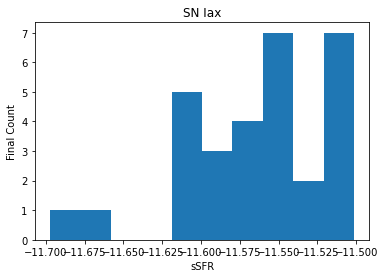

In [14]:
plt.hist(passive_iax)
plt.xlabel("sSFR")
plt.ylabel("Final Count")
plt.title("SN Iax")

(array([2., 0., 0., 0., 7., 3., 6., 3., 3., 6.]),
 array([2.0068181e-12, 2.1214096e-12, 2.2360011e-12, 2.3505928e-12,
        2.4651843e-12, 2.5797758e-12, 2.6943673e-12, 2.8089588e-12,
        2.9235505e-12, 3.0381420e-12, 3.1527335e-12], dtype=float32),
 <BarContainer object of 10 artists>)

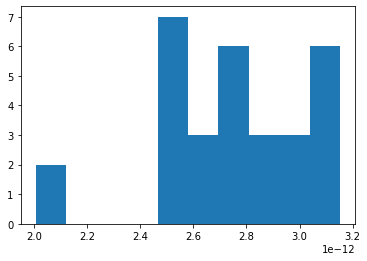

In [15]:
plt.hist(ssfr_iax.loc[(np.log10(ssfr_iax)<-11.5)])

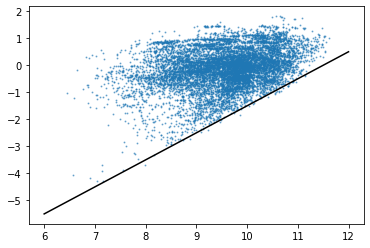

In [37]:
plt.scatter(mass_iax, sfr_iax, s=1, alpha=.5)
x = np.arange(6,13)

y = -11.5+x
plt.plot(x, y, 'k')

In [27]:
sn91bg   = collect_snana_outputs(path+"MLAG_SCOTCH10k_SNIa-91bg/")

In [28]:
sfr,mass = sn91bg['SIM_HOSTLIB(LOG_SFR)'], sn91bg['SIM_HOSTLIB(LOGMASS_TRUE)']
ssfr = 10**sfr/10**mass
active  = np.log10(ssfr[(np.log10(ssfr)>-11.5)])

In [29]:
len(active)/len(ssfr)*100

25.61

Text(0.5, 1.0, 'SN 91bg')

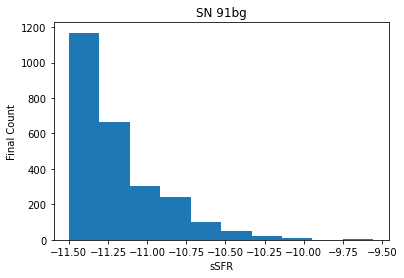

In [30]:
plt.hist(active)
plt.xlabel("sSFR")
plt.ylabel("Final Count")
plt.title("SN 91bg")

(array([3.53472244e-03, 7.67491001e-05, 1.42127963e-05, 8.52767778e-06,
        1.42127963e-06, 0.00000000e+00, 0.00000000e+00, 1.42127963e-06,
        1.42127963e-06, 1.42127963e-06]),
 array([  31.62612316,  306.35916178,  581.0922004 ,  855.82523902,
        1130.55827764, 1405.29131626, 1680.02435488, 1954.7573935 ,
        2229.49043211, 2504.22347073, 2778.95650935]),
 <BarContainer object of 10 artists>)

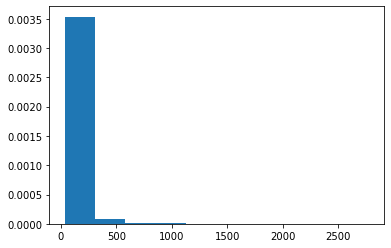

In [31]:
plt.hist(ssfr.loc[(np.log10(ssfr)>-11.5)]*10**13, density=True)
# plt.hist(ssfr_iax.loc[(np.log10(ssfr_iax)<-11.5)]*10**13, density=True)

In [32]:
max(ssfr)

2.7789565093527813e-10

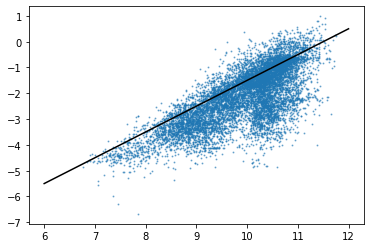

In [36]:
plt.scatter(mass, sfr, s=1, alpha=.5)
x = np.arange(6,13)
y = -11.5+x
plt.plot(x, y, 'k')

In [38]:
# set plot settings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 18})

In [39]:
# get DES supernova data

In [40]:
sndes = pd.read_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DES3YR.csv", delim_whitespace=True)

In [41]:
sndes

,TRANSIENT_NAME,SNID,ZHD,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_I,MAG_I_ERR,MAG_Z,MAG_Z_ERR,LOG_MSTELLAR,LOG_MSTELLAR_ERR,LOG_sSFR,PHOTO_CATALOGUE
0,DES13C3dgs,1248677,0.3502,21.80,0.01,21.04,0.01,20.81,0.01,20.59,0.01,9.57,0.03,-8.48,W19
1,DES13S1qv,1250017,0.1817,22.17,0.01,21.60,0.01,21.37,0.01,21.25,0.01,8.78,0.05,-8.69,W19
2,DES13C1hwx,1253039,0.4535,24.01,0.04,23.04,0.02,22.56,0.03,22.36,0.03,9.39,0.07,-9.91,W19
3,DES13E1goh,1253101,0.4596,25.48,0.11,24.32,0.05,24.22,0.07,23.81,0.06,8.57,0.08,-8.68,W19
4,DES13C1juw,1253920,0.1956,22.18,0.01,21.13,0.01,20.68,0.01,20.53,0.01,9.43,0.04,-14.40,W19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,DES15X1oqk,1345594,0.4224,21.11,0.01,19.59,0.01,19.00,0.01,18.63,0.01,11.14,0.06,-9.97,W19
202,DES15C1olp,1346137,0.3635,21.29,0.01,20.49,0.01,20.25,0.01,19.91,0.01,9.89,0.03,-8.76,W19
203,DES15C3omh,1346387,0.3445,24.60,0.13,23.33,0.05,22.63,0.03,23.01,0.09,9.04,0.08,-12.48,W19
204,DES15C2oxn,1346956,0.3335,27.02,0.21,26.51,0.16,26.54,0.23,26.29,0.32,6.90,0.25,-8.19,W19


In [42]:
logm_des    = sndes['LOG_MSTELLAR']
logssfr_des = sndes['LOG_sSFR']
logsfr_des  = np.log10(10**logssfr_des*10**logm_des)

In [45]:
ls /global/cscratch1/sd/kessler/SNANA_LSST_SIM/SCOTCH10k/

MLAG_SCOTCH10k_AGN01/                  MLAG_SCOTCH10k_SNIIn-MOSFIT/
MLAG_SCOTCH10k_AGN20/                  MLAG_SCOTCH10k_SNIa-91bg/
MLAG_SCOTCH10k_KN_B19/                 MLAG_SCOTCH10k_SNIa-SALT2/
MLAG_SCOTCH10k_KN_K17/                 MLAG_SCOTCH10k_SNIax/
MLAG_SCOTCH10k_SLSN-I/                 MLAG_SCOTCH10k_SNIb+HostXT_V19/
MLAG_SCOTCH10k_SNII+HostXT_V19/        MLAG_SCOTCH10k_SNIb-Templates/
MLAG_SCOTCH10k_SNII+HostXT_V19.tar.gz  MLAG_SCOTCH10k_SNIc+HostXT_V19/
MLAG_SCOTCH10k_SNII-NMF/               MLAG_SCOTCH10k_SNIc+HostXT_V19.tar.gz
MLAG_SCOTCH10k_SNII-Templates/         MLAG_SCOTCH10k_SNIc-Templates/
MLAG_SCOTCH10k_SNIIb+HostXT_V19/       MLAG_SCOTCH10k_SNIcBL+HostXT_V19/
MLAG_SCOTCH10k_SNIIn+HostXT_V19/       MLAG_SCOTCH10k_TDE/


In [43]:
path = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/SCOTCH10k/"
hosts_hostlib_wgt   = collect_snana_outputs(path+"MLAG_GP_ELASTICC_MODRATE_SNIa-SALT2/")
hosts_hostlib_nowgt = collect_snana_outputs(path+"MLAG_GP_ELASTICC_TEST_SMALL_SNIa-SALT2_NOWGT/")
hosts_randlib_wgt   = collect_snana_outputs(path+"MLAG_GP_ELASTICC_TEST_SMALL_SNIa-SALT2_RANDHOST/")

KeyboardInterrupt: 

In [12]:
hw_idx  = hosts_hostlib_wgt['HOSTGAL_OBJID']
hnw_idx = hosts_hostlib_nowgt['HOSTGAL_OBJID']
rw_idx  = hosts_randlib_wgt['HOSTGAL_OBJID']
quantities = ['Mag_true_r_sdss_z0', 'Mag_true_g_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0']
absmag_hw  = pull_cosmodc2_props(quantities, hw_idx)
absmag_hnw = pull_cosmodc2_props(quantities, hnw_idx)
absmag_rw  = pull_cosmodc2_props(quantities, rw_idx)

In [13]:
u_hw,g_hw,r_hw,i_hw,z_hw,ellip_hw,rshift_hw,gr_hw,iz_hw,logmass_hw,sfr_hw = snhost_props(hosts_hostlib_wgt)
u_hnw,g_hnw,r_hnw,i_hnw,z_hnw,ellip_hnw,rshift_hnw,gr_hnw,iz_hnw,logmass_hnw,sfr_hnw = snhost_props(hosts_hostlib_nowgt)
u_rw,g_rw,r_rw,i_rw,z_rw,ellip_rw,rshift_rw,gr_rw,iz_rw,logmass_rw,sfr_rw = snhost_props(hosts_randlib_wgt)

In [14]:
hostlib = pd.read_csv("/global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/ELASTICC/HOSTLIB/SNIa_GHOST.HOSTLIB.gz", sep='  ', header=24)

<ipython-input-14-b9c47fcfc646>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hostlib = pd.read_csv("/global/cfs/cdirs/lsst/groups/SN/snana/SURVEYS/LSST/ROOT/ELASTICC/HOSTLIB/SNIa_GHOST.HOSTLIB.gz", sep='  ', header=24)


In [15]:
hostlib

,VARNAMES:,GALID,RA_GAL,DEC_GAL,ZTRUE,ZPHOT,ZPHOT_ERR,u_obs,u_obs_err,g_obs,...,a1_Sersic,b1_Sersic,n1_Sersic,w1_Sersic,a_rot,ELLIPTICITY,LOGMASS,LOG_SFR,OBJID2,NBR_LIST
0,GAL:,5875000076,57.123343,-34.114445,0.052463,0.052463,0.01,21.377440,0.008336,19.668705,...,0.957731,0.929958,4,0.663529,105.908701,0.056111,8.797673,-2.625128,-999.0,-1
1,GAL:,5875000084,56.727811,-33.326844,0.084224,0.084224,0.01,17.773468,0.005034,16.118431,...,2.329567,1.406439,4,0.962656,19.844075,0.550987,10.571904,-2.515674,-999.0,-1
2,GAL:,5875000087,56.751970,-33.360994,0.054004,0.054004,0.01,19.779242,0.005368,18.216545,...,1.325300,1.125130,4,0.963248,16.066011,0.201698,9.293495,-4.047179,-999.0,-1
3,GAL:,5875000113,56.708841,-34.838314,0.066985,0.066985,0.01,21.254880,0.007775,20.132664,...,0.992316,0.973334,4,0.263091,85.258915,0.326300,7.955347,-0.693281,-999.0,20423
4,GAL:,5875000116,56.111860,-34.587675,0.051988,0.051988,0.01,17.401972,0.005024,15.660152,...,6.239789,5.849512,4,0.765122,39.676064,0.106041,10.849081,-1.031274,-999.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486902,GAL:,9875004684,69.989644,-39.649018,0.028277,0.028277,0.01,21.694948,0.010047,20.011372,...,0.405951,0.375505,4,0.170518,21.854919,0.148690,9.981431,-3.281598,-999.0,-1
1486903,GAL:,9937504892,73.135879,-39.263294,0.039999,0.039999,0.01,19.265320,0.005188,17.996092,...,1.235908,1.070564,4,0.772759,38.229018,0.111525,10.629053,0.740590,-999.0,-1
1486904,GAL:,9937500004,73.210585,-39.169280,0.046915,0.046915,0.01,16.339012,0.005008,14.736051,...,13.131329,12.518106,4,0.476287,125.447183,0.043124,10.638613,-1.122160,-999.0,-1
1486905,GAL:,9937505018,72.958257,-39.135188,0.047217,0.047217,0.01,22.199442,0.014470,20.615013,...,0.620833,0.591895,4,0.589835,27.772955,0.019247,9.297969,-0.708797,-999.0,-1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


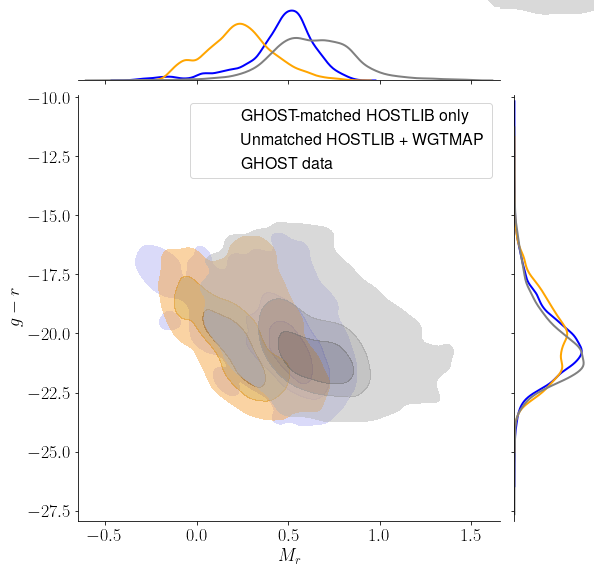

In [16]:
g = sns.JointGrid(height=8)
x, y = absmag_hnw['Mag_true_g_sdss_z0']-absmag_hnw['Mag_true_r_sdss_z0'], absmag_hnw['Mag_true_r_sdss_z0']
sns.kdeplot(x=x, y=y, color="b", ax=g.ax_joint, label='GHOST-matched HOSTLIB only', levels=4, fill=True, alpha=.5)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='blue')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='blue')


x2, y2 = absmag_rw['Mag_true_g_sdss_z0']-absmag_rw['Mag_true_r_sdss_z0'], absmag_rw['Mag_true_r_sdss_z0']
sns.kdeplot(x=x2, y=y2, color="orange", ax=g.ax_joint, label='Unmatched HOSTLIB + WGTMAP', levels=4, fill=True, alpha=.5)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y2, linewidth=2, ax=g.ax_marg_y, color='orange')
sns.kdeplot(x=x2, linewidth=2, ax=g.ax_marg_x, color='orange')

x3, y3 = g_gr, gR
sns.kdeplot(x=x3, y=y3, color="gray", ax=g.ax_joint, label='GHOST data', levels=4, fill=True, alpha=.5)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='gray')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='gray')
# plt.legend()
legend_properties = {'size':16}

g.ax_joint.legend(prop=legend_properties)
g.set_axis_labels("$M_r$", "$g-r$")


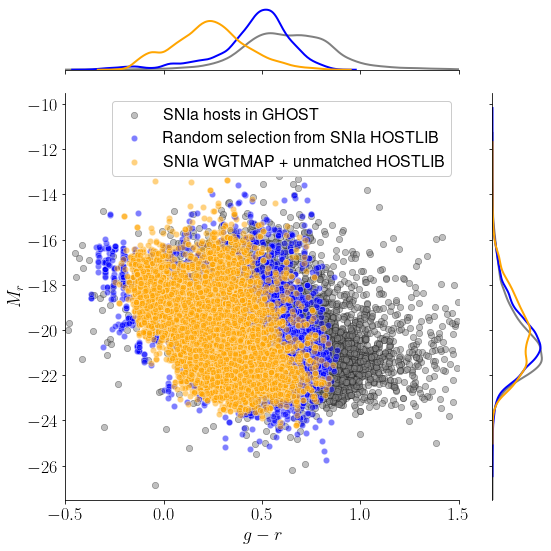

In [63]:
g = sns.JointGrid(height=8, xlim=[-.5, 1.5], ylim=[-27.5,-9.5])


x3, y3 = g_gr, gR
sns.scatterplot(x=x3, y=y3, color="gray", ec='black', s=40, alpha=.5, ax=g.ax_joint, label='SNIa hosts in GHOST')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='gray')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='gray')
# plt.legend()
legend_properties = {'size':16}

x, y = absmag_hnw['Mag_true_g_sdss_z0']-absmag_hnw['Mag_true_r_sdss_z0'], absmag_hnw['Mag_true_r_sdss_z0']
sns.scatterplot(x=x, y=y, color="b", s=40, alpha=.5, ax=g.ax_joint, label='Random selection from SNIa HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='blue')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='blue')

x2, y2 = absmag_rw['Mag_true_g_sdss_z0']-absmag_rw['Mag_true_r_sdss_z0'], absmag_rw['Mag_true_r_sdss_z0']
sns.scatterplot(x=x2, y=y2, color="orange", s=40, alpha=.5, ax=g.ax_joint, label='SNIa WGTMAP + unmatched HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y2, linewidth=2, ax=g.ax_marg_y, color='orange')
sns.kdeplot(x=x2, linewidth=2, ax=g.ax_marg_x, color='orange')

g.ax_joint.legend(prop=legend_properties, framealpha=1)
g.set_axis_labels("$g-r$", "$M_r$")
plt.tight_layout()
plt.savefig("../plots/snia-color-mag-incomplete-runs.png")


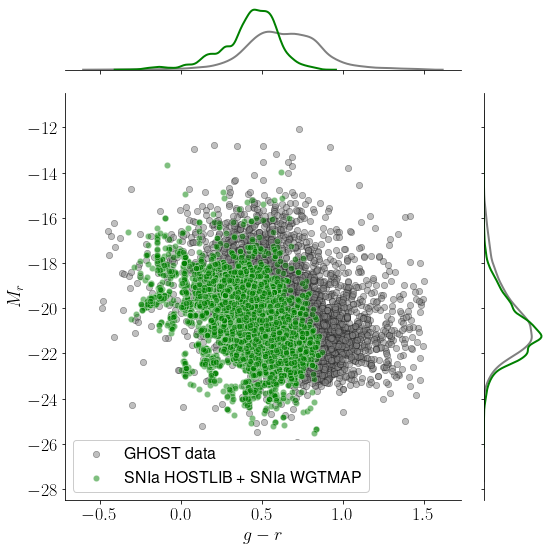

In [62]:
g = sns.JointGrid(height=8)



x3, y3 = g_gr, gR
sns.scatterplot(x=x3, y=y3, color="gray", ec='black', s=40, alpha=.5, ax=g.ax_joint, label='GHOST data')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='gray')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='gray')
# plt.legend()
legend_properties = {'size':16}

x, y = absmag_hw['Mag_true_g_sdss_z0']-absmag_hw['Mag_true_r_sdss_z0'], absmag_hw['Mag_true_r_sdss_z0']
sns.scatterplot(x=x, y=y, color="green", s=40, alpha=.5, ax=g.ax_joint, label='SNIa HOSTLIB + SNIa WGTMAP')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='green')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='green')



g.ax_joint.legend(prop=legend_properties, framealpha=1)
g.set_axis_labels("$g-r$", "$M_r$")
plt.tight_layout()
plt.savefig("../plots/snia-color-mag-complete-runs.png")


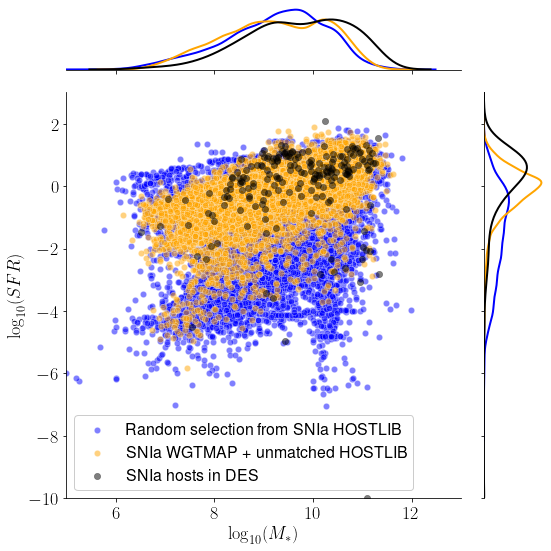

In [64]:
g = sns.JointGrid(height=8, xlim=[5,13], ylim=[-10,3])

x2, y2 = logmass_hnw, sfr_hnw
sns.scatterplot(x=x2, y=y2, color="b", s=40, alpha=.5, ax=g.ax_joint, label='Random selection from SNIa HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y2, linewidth=2, ax=g.ax_marg_y, color='blue')
sns.kdeplot(x=x2, linewidth=2, ax=g.ax_marg_x, color='blue')

x3, y3 = logmass_rw, sfr_rw
sns.scatterplot(x=x3, y=y3, color="orange", s=40, alpha=.5, ax=g.ax_joint, label='SNIa WGTMAP + unmatched HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='orange')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='orange')

x, y = logm_des, logsfr_des
sns.scatterplot(x=x, y=y, color="black", ec='black', s=40, alpha=.5, ax=g.ax_joint, label='SNIa hosts in DES')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='k')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='k')
# plt.legend()
legend_properties = {'size':16}

g.ax_joint.legend(prop=legend_properties, framealpha=1)
# g.set_xlim([5,13])
# plt.ylim([-10,3])
g.set_axis_labels("$\log_{10}(M_*)$", "$\log_{10}(SFR)$")
plt.tight_layout()
plt.savefig("../plots/snia-sfr-m-incomplete-runs.png")


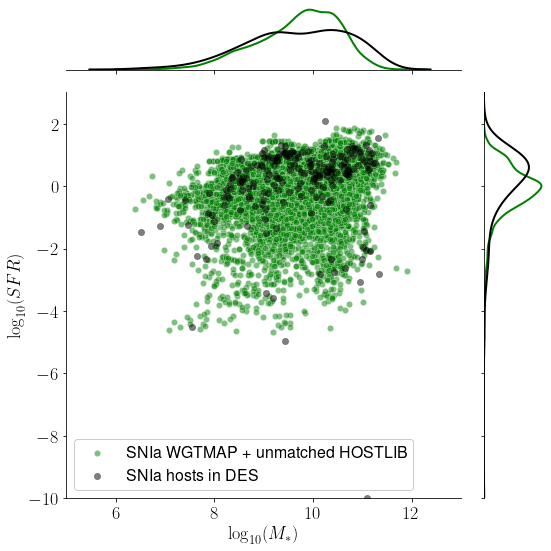

In [60]:
g = sns.JointGrid(height=8, xlim=[5,13], ylim=[-10,3])

x3, y3 = logmass_hw, sfr_hw
sns.scatterplot(x=x3, y=y3, color="green", s=40, alpha=.5, ax=g.ax_joint, label='SNIa WGTMAP + unmatched HOSTLIB')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y3, linewidth=2, ax=g.ax_marg_y, color='green')
sns.kdeplot(x=x3, linewidth=2, ax=g.ax_marg_x, color='green')

x, y = logm_des, logsfr_des
sns.scatterplot(x=x, y=y, color="black", ec='black', s=40, alpha=.5, ax=g.ax_joint, label='SNIa hosts in DES')
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color='k')
sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color='k')
# plt.legend()
legend_properties = {'size':16}


g.ax_joint.legend(prop=legend_properties, framealpha=1)

g.set_axis_labels("$\log_{10}(M_*)$", "$\log_{10}(SFR)$")
plt.tight_layout()
plt.savefig("../plots/snia-sfr-m-complete-runs.png")

# Comparing u-r between SN Ia subclasses

In [ ]:
def gcr_pull():
    

In [67]:
absmag_hw['Mag_true_u_sdss_z0']-absmag_hw['Mag_true_r_sdss_z0']

2      0.580428
3      0.363236
9      0.758827
10     0.754372
13     0.361756
         ...   
214    0.847848
215    0.874358
216    0.786042
218    0.826413
220    0.888927
Name: REDSHIFT_FINAL, Length: 3752, dtype: float32

/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

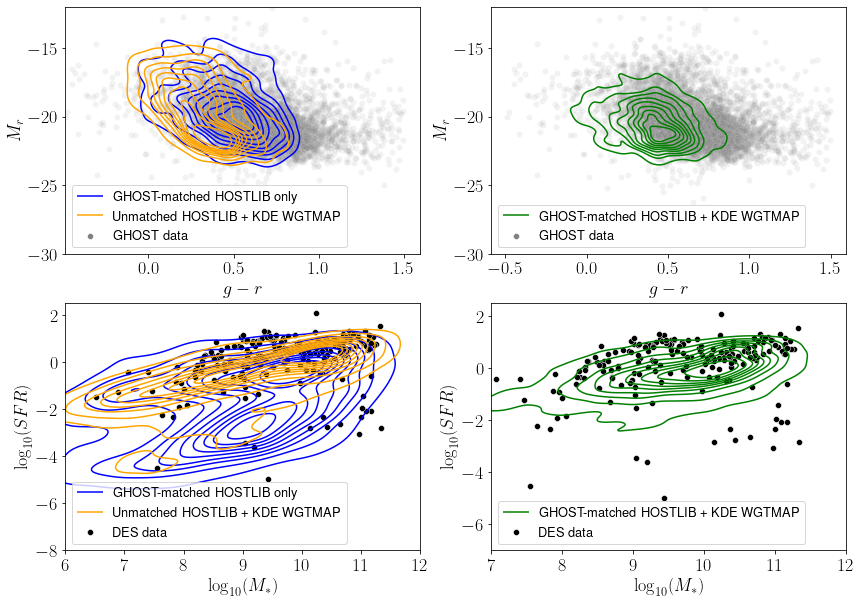

In [113]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[14,10])
sns.kdeplot(x=gr_hnw, y=R_hnw, ax=ax1, label='GHOST-matched HOSTLIB only', color='blue')
sns.kdeplot(x=gr_rw, y=R_rw, ax=ax1, label='Unmatched HOSTLIB + KDE WGTMAP', color='orange')
sns.scatterplot(g_gr, gR, ax=ax1, label='GHOST data', color='.5', alpha=.1)
leg1 = ax1.legend(fontsize=13)
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
ax1.set_ylim([-30,-12])
ax1.set_xlabel("$g-r$")
ax1.set_ylabel("$M_r$")

sns.kdeplot(x=gr_hw, y=R_hw, ax=ax2, label='GHOST-matched HOSTLIB + KDE WGTMAP', color='green')
sns.scatterplot(g_gr, gR, ax=ax2, label='GHOST data', color='.5', alpha=.1)
# sns.kdeplot(g_gr, gR,  label='GHOST data', color='grey')
leg2 = ax2.legend(fontsize=13)
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
ax2.set_ylim([-30,-12])
ax2.set_xlabel("$g-r$")
ax2.set_ylabel("$M_r$")

sns.kdeplot(x=logmass_hnw, y=sfr_hnw, ax=ax3, label='GHOST-matched HOSTLIB only', color='blue')
sns.kdeplot(x=logmass_rw, y=sfr_rw, ax=ax3, label='Unmatched HOSTLIB + KDE WGTMAP', color='orange')
sns.scatterplot(logm_des, logsfr_des, ax=ax3, label='DES data', color='k')
ax3.legend(fontsize=13)
ax3.set_ylim([-8,2.5])
ax3.set_xlim([6,12])
ax3.set_xlabel("$\log_{10}(M_*)$")
ax3.set_ylabel("$\log_{10}(SFR)$")

sns.kdeplot(x=logmass_hw, y=sfr_hw, ax=ax4, label='GHOST-matched HOSTLIB + KDE WGTMAP', color='green')
sns.scatterplot(logm_des, logsfr_des, ax=ax4, label='DES data', color='k')
ax4.legend(fontsize=13)
ax4.set_ylim([-7,2.5])
ax4.set_xlim([7,12])
ax4.set_xlabel("$\log_{10}(M_*)$")
ax4.set_ylabel("$\log_{10}(SFR)$")

plt.savefig("plots/snia_comparisons_hostlib_wgtmap.png")

/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\log_{10}(SFR)$')

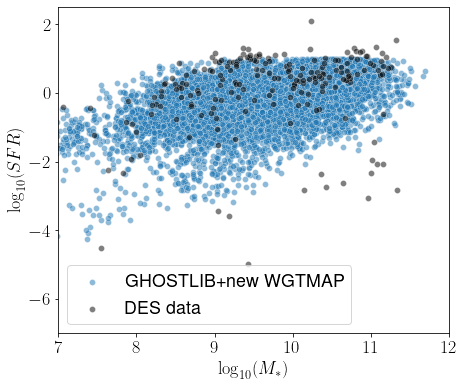

In [153]:
plt.figure(figsize=[7,6])

# sns.scatterplot(x=logmass_hnw, y=sfr_hnw, alpha=.5, label='GHOSTLIB only')
sns.scatterplot(x=logmass_hw, y=sfr_hw, alpha=.5, label='GHOSTLIB+new WGTMAP')
# sns.scatterplot(x=logmass_rw, y=sfr_rw, alpha=.5, label='Random HOSTLIB+WGTMAP')
sns.scatterplot(logm_des, logsfr_des, alpha=.5, label='DES data', color='k')
plt.legend()
plt.ylim([-7,2.5])
plt.xlim([7,12])
plt.xlabel("$\log_{10}(M_*)$")
plt.ylabel("$\log_{10}(SFR)$")

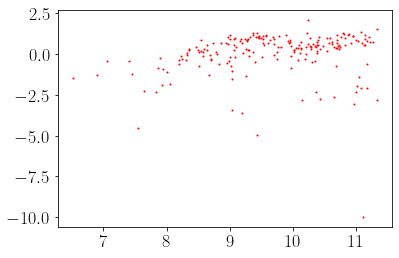

In [99]:
plt.plot(logm_des, logsfr_des, 'ro', ms=1)

In [93]:
15/206

0.07281553398058252

In [108]:
gI

0      -21.025162
1      -21.822210
2      -21.734948
3      -19.034340
4      -22.746024
          ...    
8385   -19.176370
8386   -21.755085
8387   -21.059128
8388   -20.936805
8389   -19.564924
Name: iKronMag_SDSS_abs, Length: 8390, dtype: float64

In [114]:
np.amax(gI)

inf

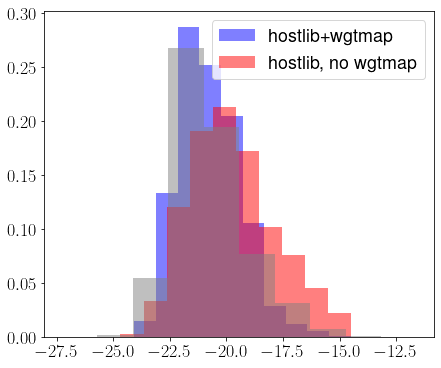

In [123]:
plt.figure(figsize=[7,6])
plt.hist(I_hw,color='blue', alpha=.5, density=True, label='hostlib+wgtmap')
plt.hist(I_hnw,color='red', alpha=.5,density=True, label='hostlib, no wgtmap')
plt.hist(gI, color='gray', alpha=.5,density=True)
plt.legend()
# plt.plot(logmass_hnw, sfr_hnw, 'g^', ms=1)
# plt.plot(logm_des, logsfr_des, 'ro')
# plt.ylim([-6,2.5])
# plt.xlim([7,12])
# plt.xlabel("$M_*$")
# plt.ylabel("SFR")

In [10]:
des_hostlib = pd.read_csv("/global/cfs/cdirs/lsst/groups/SN/snana/SNDATA_ROOT/simlib/DES/V21_DES_SVA2.HOSTLIB", sep=' ', header=22)
des_sva_logm = des_hostlib['LOGMASS']
des_sva_logsfr = des_hostlib['LOG_SFR']
des_sva_r = des_hostlib['r_obs']
des_sva_z = des_hostlib['ZTRUE']
des_cond = (des_sva_r<24) & (des_sva_z<1)